<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.00000

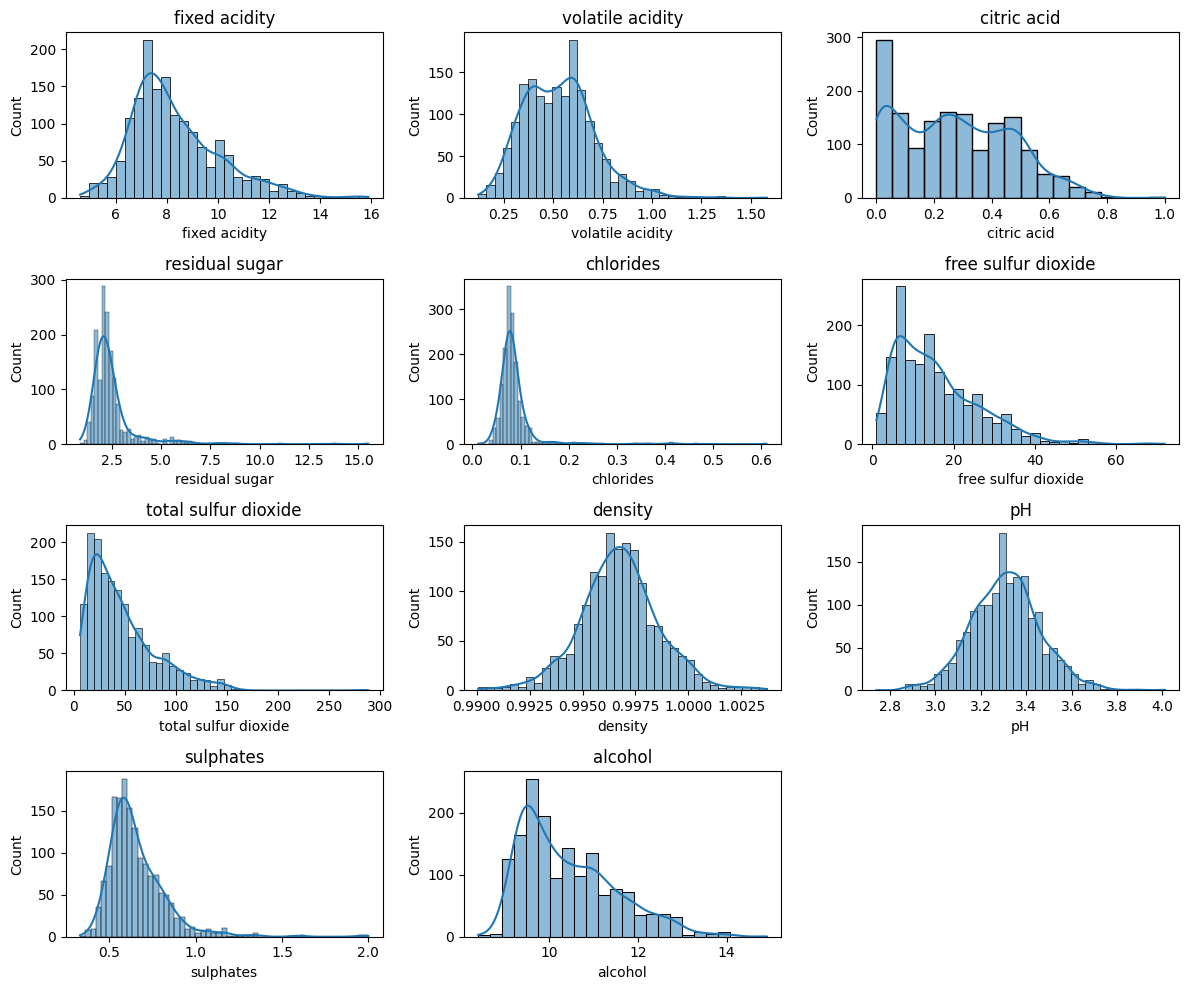

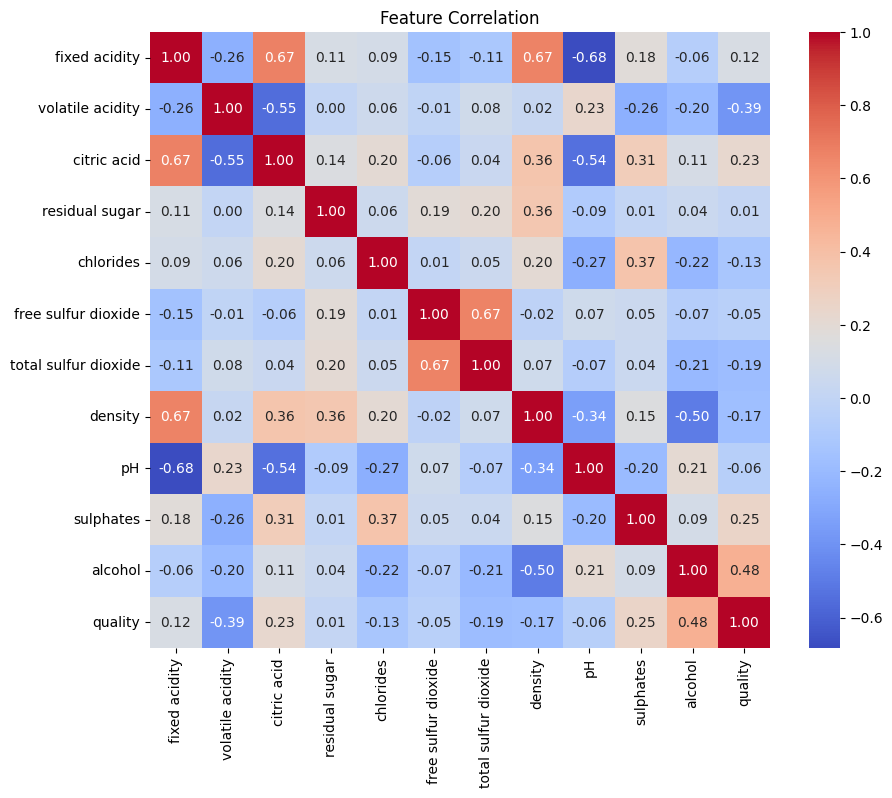

                 feature          VIF
0          fixed acidity    74.452265
1       volatile acidity    17.060026
2            citric acid     9.183495
3         residual sugar     4.662992
4              chlorides     6.554877
5    free sulfur dioxide     6.442682
6   total sulfur dioxide     6.519699
7                density  1479.287209
8                     pH  1070.967685
9              sulphates    21.590621
10               alcohol   124.394866
KNN Best params: {'n_neighbors': 9}
KNN Test RMSE: 0.642, R²: 0.369
Linear Regression CV RMSE: 0.662
Linear Regression Test RMSE: 0.625, R²: 0.403


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 로드
df = pd.read_csv('winequality-red.csv')

# 2. 기초 정보 확인
print(df.info())
print(df.describe())

# 3. 결측치 확인
print(df.isnull().sum())

# 4. 특성별 분포 시각화
plt.figure(figsize=(12,10))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(4,3,i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# 5. 상관관계 히트맵
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# 6. 다중공선성 확인 (VIF)
X = df.drop('quality', axis=1)
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_data)

# 7. 학습/검증 데이터 분할
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 8. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 9. KNN 회귀로 와인 품질 예측
knn = KNeighborsRegressor()
param_knn = {'n_neighbors': [3,5,7,9]}
grid_knn = GridSearchCV(knn, param_knn, cv=5, scoring='neg_mean_squared_error')
grid_knn.fit(X_train_scaled, y_train)
y_pred_knn = grid_knn.predict(X_test_scaled)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn   = r2_score(y_test, y_pred_knn)
print(f'KNN Best params: {grid_knn.best_params_}')
print(f'KNN Test RMSE: {rmse_knn:.3f}, R²: {r2_knn:.3f}')

# 10. 선형회귀로 와인 품질 예측
lr = LinearRegression()
scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_lr_cv = np.sqrt(-scores).mean()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr   = r2_score(y_test, y_pred_lr)
print(f'Linear Regression CV RMSE: {rmse_lr_cv:.3f}')
print(f'Linear Regression Test RMSE: {rmse_lr:.3f}, R²: {r2_lr:.3f}')
